# In Progress (Coming Soon)
## 04g - Vertex AI > Pipelines - Forecasting Tournament with Kubeflow (KFP) and BQML + AutoML + Prophet


### Prerequisites:
-  04 - Time Series Forecasting - Data Review in BigQuery

### Overview:
-  

### Resources:
-  

---
## Vertex AI - Conceptual Flow

<img src="architectures/slides/04g_arch.png">

---
## Vertex AI - Workflow

<img src="architectures/slides/04g_console.png">

---
# DEV NOTES

KFP
- prepare data: raw > forecast (Transform, add splits) and create dataset (for automl)
- Launch Forecasting
    - ARIMA+
        - fit
            - Output to BigQuery
            - Post-Process Predictions
        - Calc Metrics
    - AutoML
        - Parallel CW scenarios [32, 16, 8, 4, 2, 1, 0]
            - fit
                - Launch Vertex AI AutoML Forecasting Training Job
                    - Output to BigQuery
                - Post-Process Predictions
            - Calc Metrics
    - Prophet
        - Parallel Scenarios (yearly flag):
            - fit
                - Launch Vertex AI Training Jobs - use 04f container
                    - Output to BigQuery
                - Post Process Predictions
- Create Best Method - Use combined predictions table from the individual post-processing
- Create Best Series

The AutoML component will need to run 7 concurrent jobs
The default limit is 5 per: https://cloud.google.com/vertex-ai/docs/quotas#model_quotas
I updated this to 10 with IAM > Quota using this instructions: https://cloud.google.com/docs/quota#requesting_higher_quota



---
## Setup

inputs:

In [1]:
PROJECT_ID='statmike-demo3'
REGION = 'us-central1'
DATANAME = 'citibikes'
NOTEBOOK = '04g'

# Used for Prophet Custom Forecasting Jobs
BASE_IMAGE = 'gcr.io/deeplearning-platform-release/base-cpu'
BQ_SOURCE = 'bigquery-public-data.new_york.citibike_trips'

packages:

In [2]:
from google.cloud import bigquery
from google.cloud import aiplatform

from typing import NamedTuple
import kfp # used for dsl.pipeline
import kfp.v2.dsl as dsl # used for dsl.component, dsl.Output, dsl.Input, dsl.Artifact, dsl.Model, ...
from google_cloud_pipeline_components import aiplatform as gcc_aip

import matplotlib.pyplot as plt
from datetime import datetime
import json

clients:

In [3]:
aiplatform.init(project=PROJECT_ID, location=REGION)
bigquery = bigquery.Client()

parameters:

In [4]:
BUCKET = PROJECT_ID
URI = f"gs://{BUCKET}/{DATANAME}/models/{NOTEBOOK}"
DIR = f"temp/{NOTEBOOK}"

In [5]:
# Give service account roles/storage.objectAdmin permissions
# Console > IMA > Select Account <projectnumber>-compute@developer.gserviceaccount.com > edit - give role
SERVICE_ACCOUNT = !gcloud config list --format='value(core.account)' 
SERVICE_ACCOUNT = SERVICE_ACCOUNT[0]
SERVICE_ACCOUNT

'715288179162-compute@developer.gserviceaccount.com'

environment:

In [6]:
!rm -rf {DIR}
!mkdir -p {DIR}

---
## Custom Components (KFP)

Vertex AI Pipelines are made up of components that run independently with inputs and outputs that connect to form a graph - the pipeline.  For this notebook workflow the following custom components are used to orchestrate different forcasting approaches (BigQuery ML ARIMA+, Prophet, and Vertex AI AutoML Forecasting) and the different scenearios for each of these.

### Data Preparation
This component prepares the data for forcasting and add the split for Train/Validate/Test sets.  This follows the logic used in notebok `04`.

In [131]:
@dsl.component(
    base_image = "python:3.9",
    packages_to_install = ['pandas','pyarrow','google-cloud-bigquery', 'google-cloud-aiplatform']
)
def forecast_prep(
    project: str,
    region: str,
    notebook: str,
    bqsource: str,
) -> NamedTuple('source', [('fh', int), ('bqdataset', str), ('bqtable', str), ('bqmain', str), ('bqtable_query', str), ('bqmain_query', str), ('dataset_resource_name', str)]):

    # Setup
    from collections import namedtuple
    sources = namedtuple('source', ['fh', 'bqdataset', 'bqtable', 'bqmain', 'bqtable_query', 'bqmain_query', 'dataset_resource_name'])
    
    from google.cloud import bigquery
    bigquery = bigquery.Client(project = project)
    
    from google.cloud import aiplatform
    aiplatform.init(project=project, location=region)
    
    # parameters
    bqdataset = f"{notebook}_tournament"
    bqtable = f'{project}.{bqdataset}.source'
    bqmain = f'{project}.{bqdataset}.tournament'
    
    # Create Schema
    query = f"""
        CREATE SCHEMA IF NOT EXISTS `{project}.{bqdataset}`
        OPTIONS(location = 'US', labels = [('notebook','{notebook}')])
    """
    job = bigquery.query(query = query)
    job.result()
    
    # Plan Cutoff dates
    query = f"""
        WITH
            ALLDATES AS(
                SELECT EXTRACT(DATE from starttime) as date
                FROM `{bqsource}`
                WHERE start_station_name LIKE '%Central Park%'
            ),
            KEYS AS(
                SELECT 
                    MIN(date) as start_date,
                    MAX(date) - CAST(0.025 * DATE_DIFF(MAX(date), MIN(date), DAY) AS INT64) as val_start,
                    MAX(date) - CAST(0.0125 * DATE_DIFF(MAX(date), MIN(date), DAY) AS INT64) test_start,
                    MAX(date) as end_date
                FROM ALLDATES  
            )
        SELECT *, DATE_DIFF(end_date, test_start, DAY)+1 as forecast_horizon
        FROM KEYS    
    """
    keyDates = bigquery.query(query = query).to_dataframe()
    
    # Prepare Source
    queryTable = f"""
        CREATE OR REPLACE TABLE `{bqtable}` AS
        WITH
            DAYS AS(
                SELECT
                   start_station_name,
                   EXTRACT(DATE from starttime) AS date,
                   COUNT(*) AS num_trips
                FROM `{bqsource}`
                WHERE start_station_name LIKE '%Central Park%'
                GROUP BY start_station_name, date
            ),
            FUTURE AS (
                SELECT *
                FROM (SELECT DISTINCT start_station_name FROM DAYS) A
                CROSS JOIN (SELECT * FROM UNNEST(GENERATE_DATE_ARRAY(
                    DATE({keyDates['test_start'][0].strftime('%Y, %m, %d')}),
                    DATE_ADD(DATE({keyDates['test_start'][0].strftime('%Y, %m, %d')}), INTERVAL 2*{keyDates['forecast_horizon'][0]} DAY),
                    INTERVAL 1 DAY)) AS date) B
            ),
            COMBINE AS (
                SELECT *
                FROM DAYS
                FULL OUTER JOIN FUTURE
                USING (start_station_name, date)
            )
        SELECT *,
           CASE
               WHEN date < DATE({keyDates['val_start'][0].strftime('%Y, %m, %d')}) THEN "TRAIN"
               WHEN date < DATE({keyDates['test_start'][0].strftime('%Y, %m, %d')}) THEN "VALIDATE"
               ELSE "TEST"
           END AS splits
        FROM DAYS # COMBINE would add future days to splits=TEST
        ORDER BY start_station_name, date
    """
    job = bigquery.query(query = queryTable)
    job.result()
    
    # Prepare Common Output Table
    queryOutput = f"""
        CREATE OR REPLACE TABLE `{bqmain}`
        (platform STRING, method STRING, scenario STRING, start_station_name STRING, date DATE, num_trips INT64, yhat FLOAT64, yhat_lower FLOAT64, yhat_upper FLOAT64)
    """
    job = bigquery.query(query = queryOutput)
    job.result()
    
    # create Vertex AI Dataset linking to bqtable
    dataset = aiplatform.TimeSeriesDataset.create(
        display_name = f'{notebook}_source', 
        bq_source = f'bq://{bqtable}',
        labels = {'notebook':f'{notebook}'}
    )
    
    return sources(keyDates['forecast_horizon'][0].item(), bqdataset, bqtable, bqmain, queryTable, queryOutput, dataset.resource_name)

### BigQuery ML ARIMA+
This component fits a forecasting model using BigQuery ML model type ARIMA+.  This follows the logic used in notebook `04a`.

In [221]:
@dsl.component(
    base_image = "python:3.9",
    packages_to_install = ['pandas','pyarrow','google-cloud-bigquery']
)
def forecast_bqarima(
    project: str,
    notebook: str,
    bqtable: str,
    bqmain: str,
    fh: int
) -> NamedTuple('source', [('bqoutput', str), ('bqmodel', str), ('bq_model_query', str), ('platform', str), ('method', str), ('scenario', str)]):

    # Setup
    from collections import namedtuple
    sources = namedtuple('source', ['bqoutput', 'bqmodel', 'bq_model_query', 'platform', 'method', 'scenario'])
    
    from google.cloud import bigquery
    bigquery = bigquery.Client(project = project)
    
    # parameters
    table = bqtable.split('.')[-1]
    bqmodel = f"{bqtable[:-(len(table)+1)]}.{notebook}_arimaplus"
    bqoutput = f"{bqtable[:-(len(table)+1)]}.{notebook}_forecast_arimaplus"
    platform = 'BigQuery' 
    method = 'ARIMA_PLUS'
    scenario = 'automatic'
    
    # Create Model: ARIMA_PLUS
    queryARIMA = f"""
        CREATE OR REPLACE MODEL `{bqmodel}`
        OPTIONS
          (model_type = 'ARIMA_PLUS',
           time_series_timestamp_col = 'date',
           time_series_data_col = 'num_trips',
           time_series_id_col = 'start_station_name',
           auto_arima_max_order = 5,
           holiday_region = 'US',
           horizon = {2*fh}
          ) AS
        SELECT start_station_name, date, num_trips
        FROM `{bqtable}`
        WHERE splits in ('TRAIN','VALIDATE')
    """
    job = bigquery.query(query = queryARIMA)
    job.result()
    
    # Create Raw Output
    query = f"""
        CREATE OR REPLACE TABLE `{bqoutput}` AS
        WITH
            FORECAST AS (
                SELECT
                    start_station_name, 
                    EXTRACT(DATE from time_series_timestamp) as date,
                    time_series_adjusted_data as forecast_value,
                    time_series_type,
                    prediction_interval_lower_bound,
                    prediction_interval_upper_bound
                FROM ML.EXPLAIN_FORECAST(MODEL `{bqmodel}`, STRUCT({fh} AS horizon, 0.95 AS confidence_level))
                WHERE time_series_type = 'forecast'
            ),
            ACTUAL AS (
                SELECT start_station_name, date, sum(num_trips) as num_trips
                FROM `{bqtable}`
                WHERE splits = 'TEST'
                GROUP BY start_station_name, date
            )
        SELECT *
        FROM FORECAST
        LEFT OUTER JOIN ACTUAL
        USING (start_station_name, date)
        ORDER BY start_station_name, time_series_type, date 
    """
    job = bigquery.query(query = query)
    job.result()
    
    # Insert Output for Tournament (first remove prior run if present)
    query = f"""
        DELETE `{bqmain}`
        WHERE platform = '{platform}' and method = '{method}' and scenario = '{scenario}'
    """
    job = bigquery.query(query)
    job.result()
    query = f"""
        INSERT INTO `{bqmain}`
        SELECT
            '{platform}' as platform,
            '{method}' as method,
            '{scenario}' as scenario,
            start_station_name,
            date,
            num_trips,
            forecast_value as yhat,
            prediction_interval_lower_bound as yhat_lower,
            prediction_interval_upper_bound as yhat_upper
        FROM `{bqoutput}`
        ORDER by start_station_name, date
    """
    job = bigquery.query(query = query)
    job.result()
    
    return sources(bqoutput, bqmodel, queryARIMA, platform, method, scenario)

### Vertex AI AutoML Forecasting
This component fits a forecasting model using Vertex AI AutoML Forecasting.  This follows the logic used in notebooks `04c` and `04d`.

In [126]:
@dsl.component(
    base_image = "python:3.9",
    packages_to_install = ['google-cloud-bigquery','google-cloud-aiplatform']
)
def forecast_automl(
    project: str,
    region: str,
    notebook: str,
    bqtable: str,
    bqmain: str,
    ds: str, # vertex ai dataset.resource_name
    cw: int, # context window
    fh: int # forecast horizon
) -> NamedTuple('source', [('bqoutput', str), ('model', str), ('platform', str), ('method', str), ('scenario', str)]):

    # Setup
    from collections import namedtuple
    sources = namedtuple('source', ['bqoutput', 'model', 'platform', 'method', 'scenario'])
    
    from google.cloud import bigquery
    bigquery = bigquery.Client(project = project)
    
    from google.cloud import aiplatform
    aiplatform.init(project=project, location=region)
    
    # parameters
    table = bqtable.split('.')[-1]
    bqoutput = f"{bqtable[:-(len(table)+1)]}.{notebook}_forecast_automl_{cw}"
    platform = 'Vertex AI' 
    method = 'AutoML'
    scenario = f'cw={cw}'
    
    # dataset
    dataset = aiplatform.TimeSeriesDataset(ds)
    
    # Delete output table from BigQuery (in case previously run created it)
    query = f"""
        DROP TABLE IF EXISTS `{bqoutput}`
    """
    job = bigquery.query(query = query)
    job.result()
    
    # Create Job
    column_specs = list(set(dataset.column_names) - set(['splits','start_station_name']))
    column_specs = dict.fromkeys(column_specs, 'auto')
    column_specs
    
    forecast_job = aiplatform.AutoMLForecastingTrainingJob(
        display_name = f'{notebook}_automl_{cw}',
        optimization_objective = "minimize-rmse",
        column_specs = column_specs,
        labels = {'notebook':f'{notebook}', 'cw': f'{cw}'}
    )
    
    # Run Job
    forecast = forecast_job.run(
        dataset = dataset,
        target_column = "num_trips",
        time_column = "date",
        time_series_identifier_column = "start_station_name",
        unavailable_at_forecast_columns = ["num_trips",],
        available_at_forecast_columns = ["date",],
        forecast_horizon = 2*fh,
        data_granularity_unit = "day",
        data_granularity_count = 1,
        predefined_split_column_name = "splits",
        context_window = cw,
        export_evaluated_data_items = True,
        export_evaluated_data_items_bigquery_destination_uri = f"bq://{bqoutput.replace('.',':')}",
        validation_options = "fail-pipeline",
        budget_milli_node_hours = 100,
        model_display_name = f"{notebook}_automl_{cw}",
        model_labels = {'notebook':f'{notebook}', 'cw': f'{cw}'}
    )
        
    # Insert Output for Tournament (first remove prior run if present)
    query = f"""
        DELETE `{bqmain}`
        WHERE platform = '{platform}' and method = '{method}' and scenario = '{scenario}'
    """
    job = bigquery.query(query)
    query = f"""
        INSERT INTO `{bqmain}`
        WITH
            FORECASTS AS (
                SELECT
                    DATE(date) as date,
                    DATE(predicted_on_date) as predicted_on_date,
                    CAST(num_trips as INT64) AS num_trips, splits,
                    start_station_name,
                    predicted_num_trips.value as predicted_num_trips
                FROM `{bqoutput}`
            ),
            LEAD_DAYS AS (
                SELECT *, DATE_DIFF(date, predicted_on_date, DAY) as prediction_lead_days
                FROM FORECASTS
            ),
            LATEST AS (
                SELECT start_station_name, date, min(prediction_lead_days) as prediction_lead_days
                FROM LEAD_DAYS
                GROUP BY start_station_name, date
            ),
            DIFFS AS (
                SELECT 
                    start_station_name, date,
                    predicted_num_trips as forecast_value,
                    num_trips
                FROM LATEST
                LEFT OUTER JOIN LEAD_DAYS
                USING (start_station_name, date, prediction_lead_days)    
            )
        SELECT
            '{platform}' as platform,
            '{method}' as method,
            '{scenario}' as scenario,
            start_station_name,
            date,
            num_trips,
            forecast_value as yhat,
            NULL as yhat_lower,
            NULL as yhat_upper
        FROM DIFFS
        ORDER by start_station_name, date
    """
    job = bigquery.query(query = query)
    job.result()

    return sources(bqoutput, forecast.resource_name, platform, method, scenario)

### Vertex AI Training Custom Jobs for Forecasting with Prophet
This component fits a forecasting model using a Prophet script in a custom container (built in `04f`) to fit forecasting.  This follows the logic used in notebook `04f`.

In [222]:
@dsl.component(
    base_image = "python:3.9",
    packages_to_install = ['google-cloud-bigquery','google-cloud-aiplatform']
)
def forecast_prophet(
    project: str,
    region: str,
    notebook: str,
    bqtable: str,
    bqmain: str,
    service_account: str,
    image_uri: str,
    yearly: str, # flag for prophet to add seasonality for yearly
    fh: int, # forecast horizon
) -> NamedTuple('source', [('bqoutput', str), ('model', str), ('platform', str), ('method', str), ('scenario', str)]):

    # Setup
    from collections import namedtuple
    sources = namedtuple('source', ['bqoutput', 'model', 'platform', 'method', 'scenario'])
    
    from google.cloud import bigquery
    bigquery = bigquery.Client(project = project)
    
    from google.cloud import aiplatform
    aiplatform.init(project=project, location=region)
    
    # parameters
    platform = 'Vertex AI' 
    method = 'Prophet Container'
    if yearly == 'true': scenario = '--yearly'
    else: scenario = '--no-yearly'
    
    table = bqtable.split('.')[-1]
    bqoutput = f"{bqtable[:-(len(table)+1)]}.{notebook}_forecast_prophet_{scenario}"
    URI = f"gs://{bqtable.split('.')[0]}/{bqtable.split('.')[1]}/models/{notebook}"
    
    # create job
    CMDARGS = [
        "--project=" + project,
        "--bqtable=" + bqtable,
        "--bqoutput=" + bqoutput,
        "--horizon=" + f'{fh}',
        f"{scenario}"
    ]

    MACHINE_SPEC = {
        "machine_type": 'n1-standard-8',
        "accelerator_count": 0
    }

    WORKER_POOL_SPEC = [
        {
            "replica_count": 1,
            "machine_spec": MACHINE_SPEC,
            "container_spec": {
                "image_uri": image_uri,
                "command": [],
                "args": CMDARGS
            }
        }
    ]
    
    customJob = aiplatform.CustomJob(
        display_name = f'{notebook}_prophet_{scenario}',
        worker_pool_specs = WORKER_POOL_SPEC,
        base_output_dir = f"{URI}/{scenario}",
        staging_bucket = f"{URI}/{scenario}",
        labels = {'notebook':f'{notebook}', 'yearly':f'{scenario}'}
    )
    
    # run job
    customJob.run(
        service_account = service_account
    )
                           
    # Insert Output for Tournament (first remove prior run if present)
    query = f"""
        DELETE `{bqmain}`
        WHERE platform = '{platform}' and method = '{method}' and scenario = '{scenario}'
    """
    job = bigquery.query(query)
    job.result()
    
    query = f"""
        INSERT INTO `{bqmain}`
        SELECT
            '{platform}' as platform,
            '{method}' as method,
            '{scenario}' as scenario,
            start_station_name,
            date,
            num_trips,
            yhat,
            yhat_lower,
            yhat_upper
        FROM `{bqoutput}`
        ORDER by start_station_name, date
    """
    job = bigquery.query(query = query)
    job.result()

    return sources(f'{bqoutput}', customJob.resource_name, platform, method, scenario)

### Custom Container Build

##### Assemble Python File For Training

In [223]:
!mkdir -p {DIR}/model/fit

In [224]:
%%writefile  {DIR}/model/fit/prophet.py
from prophet import Prophet
from google.cloud import bigquery
import pandas as pd
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
import argparse

# import parameters
parser = argparse.ArgumentParser()
parser.add_argument('--project', dest = 'project', type = str)
parser.add_argument('--bqtable', dest = 'bqtable', type = str)
parser.add_argument('--bqoutput', dest = 'bqoutput', type = str)
parser.add_argument('--horizon', type=int)

parser.add_argument('--yearly', action='store_true')
parser.add_argument('--no-yearly', action='store_false')
parser.set_defaults(yearly=False)

args = parser.parse_args()
project = args.project
bqtable = args.bqtable
bqoutput = args.bqoutput

# client for BQ
bigquery = bigquery.Client(project = project)

# input data - from BQ
query = f"SELECT * FROM `{bqtable}` ORDER by start_station_name, date"
source = bigquery.query(query = query).to_dataframe()

# preprocess data - as a list of dataframes for each series
seriesNames = source['start_station_name'].unique().tolist()
seriesFrames = []
for s in seriesNames:
    frame = source[(source['start_station_name']==s) & (source['splits']!='TEST')][['date','num_trips']].rename(columns={'date':'ds','num_trips':'y'})
    seriesFrames.append(frame)

# function to run a prophet fit & forecast
def run_prophet(series):
    if args.yearly:
        p = Prophet(weekly_seasonality=True, yearly_seasonality=True)
    else:
        p = Prophet(weekly_seasonality=True)
    p.add_country_holidays(country_name='US')
    p.fit(series)
    f = p.make_future_dataframe(periods = args.horizon, include_history = False)
    f = p.predict(f)
    return f[['ds','yhat','yhat_lower','yhat_upper']]

# run the series in a thread pool for multiprocessing
pool = Pool(cpu_count())
predictions = list(tqdm(pool.imap(run_prophet, seriesFrames), total = len(seriesFrames)))
pool.close()
pool.join()

# postprocess data - add series name back to dataframe and concatenate all into one dataframe
for i, p in enumerate(predictions):
    p['start_station_name'] = seriesNames[i]
output = pd.concat(predictions)

# output data - to BQ
output.to_gbq(f"{bqoutput}", f"{bqtable.split('.')[0]}", if_exists = 'replace')

# Transform final data in BQ - merge with original input
query = f"""
CREATE OR REPLACE TABLE `{bqoutput}` AS
WITH
    SOURCE AS (
        SELECT *
        FROM `{bqtable}`
        WHERE splits='TEST'
    ),
    PROPHET AS (
        SELECT start_station_name, DATE(ds) as date, yhat, yhat_lower, yhat_upper
        FROM `{bqoutput}`
    )
SELECT *
FROM SOURCE
LEFT OUTER JOIN PROPHET
USING (start_station_name, date)
ORDER by start_station_name, date
"""
Tjob = bigquery.query(query = query)
Tjob.result()
(Tjob.ended-Tjob.started).total_seconds()

Overwriting temp/04g/model/fit/prophet.py


##### Choose a Base Image

In [225]:
BASE_IMAGE # Defined above in Setup

'gcr.io/deeplearning-platform-release/base-cpu'

##### Create the Dockerfile
A basic dockerfile thats take the base image and copies the code in and define an entrypoint - what python script to run first in this case.  Add RUN entries to pip install additional packages.

In [226]:
dockerfile = f"""
FROM {BASE_IMAGE}
WORKDIR /
RUN pip install pandas pystan==2.19.1.1 prophet pandas-gbq google-cloud-bigquery pyarrow tqdm
## Copies the trainer code to the docker image
COPY fit /fit
## Sets up the entry point to invoke the trainer
ENTRYPOINT ["python", "-m", "fit.prophet"]
"""
with open(f'{DIR}/model/Dockerfile', 'w') as f:
    f.write(dockerfile)

##### Enable Artifact Registry API:
Check to see if the api is enabled, if not then enable it:

In [227]:
services = !gcloud services list --format="json" --available --filter=name:artifactregistry.googleapis.com
services = json.loads("".join(services))

if (services[0]['config']['name'] == 'artifactregistry.googleapis.com') & (services[0]['state'] == 'ENABLED'):
    print(f"Artifact Registry is Enabled for This Project: {PROJECT_ID}")
else:
    print(f"Enabeling Artifact Registry for this Project: {PROJECT_ID}")
    !gcloud services enable artifactregistry.googleapis.com

Artifact Registry is Enabled for This Project: statmike-demo3


##### Create A Repository
Check to see if the registry is already created, if not then create it

In [228]:
repositories = !gcloud artifacts repositories list --format="json" --filter=REPOSITORY:{PROJECT_ID}
repositories = json.loads("".join(repositories[2:]))

if len(repositories) > 0:
    print(f'There is already a repository named {PROJECT_ID}')
else:
    print(f'Creating a repository named {PROJECT_ID}')
    !gcloud  artifacts repositories create {PROJECT_ID} --repository-format=docker --location={REGION} --description="Vertex AI Training Custom Containers"

There is already a repository named statmike-demo3


##### Configure Local Docker to Use GCLOUD CLI

In [229]:
!gcloud auth configure-docker {REGION}-docker.pkg.dev --quiet


{
  "credHelpers": {
    "gcr.io": "gcloud",
    "us.gcr.io": "gcloud",
    "eu.gcr.io": "gcloud",
    "asia.gcr.io": "gcloud",
    "staging-k8s.gcr.io": "gcloud",
    "marketplace.gcr.io": "gcloud",
    "us-central1-docker.pkg.dev": "gcloud"
  }
}
Adding credentials for: us-central1-docker.pkg.dev
gcloud credential helpers already registered correctly.


##### Build The Custom Container (local to notebook)

In [230]:
IMAGE_URI=f"{REGION}-docker.pkg.dev/{PROJECT_ID}/{PROJECT_ID}/{NOTEBOOK}:latest"
IMAGE_URI

'us-central1-docker.pkg.dev/statmike-demo3/statmike-demo3/04g:latest'

In [231]:
!docker build {DIR}/model/. -t $IMAGE_URI

Sending build context to Docker daemon  6.144kB
Step 1/5 : FROM gcr.io/deeplearning-platform-release/base-cpu
 ---> bc8479139130
Step 2/5 : WORKDIR /
 ---> Using cache
 ---> e044b6f855ab
Step 3/5 : RUN pip install pandas pystan==2.19.1.1 prophet pandas-gbq google-cloud-bigquery pyarrow tqdm
 ---> Using cache
 ---> 0f84b7c3af82
Step 4/5 : COPY fit /fit
 ---> ed589ac23bad
Step 5/5 : ENTRYPOINT ["python", "-m", "fit.prophet"]
 ---> Running in 96d31572922e
Removing intermediate container 96d31572922e
 ---> 96211b58a7a9
Successfully built 96211b58a7a9
Successfully tagged us-central1-docker.pkg.dev/statmike-demo3/statmike-demo3/04g:latest


In [232]:
!docker push $IMAGE_URI

The push refers to repository [us-central1-docker.pkg.dev/statmike-demo3/statmike-demo3/04g]

6ca722df: Preparing 
407f67d9: Preparing 
c3dd1b30: Preparing 
f55e5b0f: Preparing 
b8042115: Preparing 
e7ceaeea: Preparing 
659ee3aa: Preparing 
153ced2f: Preparing 
b90e8bce: Preparing 
d686dc1d: Preparing 
c56dcfc0: Preparing 
dd09476c: Preparing 
384be1ed: Preparing 
0864cc76: Preparing 
24e4876e: Preparing 
bf18a086: Preparing 
282950fe: Preparing 
0b19050d: Preparing 
b453bec5: Preparing 
dceb4c77: Layer already exists 3kBlatest: digest: sha256:3a38d81f52f6d0f1001b4cf0a3904c844194dd19e3faff99dddec28fc7fcb8cf size: 4501


### Custom Metrics
This component calculates custom metrics for all time series and all methods to select the best method per series and prepare a champion prediction file in BigQuery.

In [118]:
@dsl.component(
    base_image = "python:3.9",
    packages_to_install = ['pandas','pyarrow','google-cloud-bigquery']
)
def forecast_metrics(
    project: str,
    notebook: str,
    bqmain: str,
    platform: str,
    method: str,
    scenario: str,
    metrics: dsl.Output[dsl.Metrics]
) -> NamedTuple('metrics', [('MAPE', float), ('MAE', float), ('pMAE', float)]):

    # Setup
    from collections import namedtuple
    sources = namedtuple('metrics', ['MAPE', 'MAE', 'pMAE'])
    
    from google.cloud import bigquery
    bigquery = bigquery.Client(project = project)
        
    # metrics
    query = f"""
        WITH
            FORECASTS AS (
                SELECT
                    platform, method, scenario,
                    date, 
                    num_trips,
                    start_station_name, 
                    yhat,
                    (num_trips - yhat) as diff
                FROM `{bqmain}`
                WHERE platform = '{platform}' and method = '{method}' and scenario = '{scenario}'
            )
        SELECT
            AVG(ABS(diff)/num_trips) as MAPE,
            AVG(ABS(diff)) as MAE,
            SUM(ABS(diff))/SUM(num_trips) as pMAE
        FROM FORECASTS
    """
    customMetrics = bigquery.query(query = query).to_dataframe()
    metrics.log_metric('MAPE', customMetrics['MAPE'][0])
    metrics.log_metric('MAE', customMetrics['MAE'][0])
    metrics.log_metric('pMAE', customMetrics['pMAE'][0])
    
    return sources(customMetrics['MAPE'][0], customMetrics['MAE'][0], customMetrics['pMAE'][0])

### Champion Selection: Overall

In [119]:
@dsl.component(
    base_image = "python:3.9",
    packages_to_install = ['pandas','pyarrow','google-cloud-bigquery']
)
def forecast_champion_method(
    project: str,
    notebook: str,
    bqmain: str,
    metrics: dsl.Output[dsl.Metrics]
) -> NamedTuple('metrics', [('bqoutput', str), ('platform', str), ('method', str), ('scenario', str), ('MAPE', float), ('MAE', float), ('pMAE', float)]):

    # Setup
    from collections import namedtuple
    sources = namedtuple('metrics', ['bqoutput', 'platform', 'method','scenario', 'MAPE', 'MAE', 'pMAE'])
    
    from google.cloud import bigquery
    bigquery = bigquery.Client(project = project)
    
    # parameter
    table = bqmain.split('.')[-1]
    bqoutput = f"{bqmain[:-(len(table)+1)]}.champion_overall"
    
    # metrics
    query = f"""
        WITH
            FORECASTS AS (
                SELECT
                    platform, method, scenario,
                    date, 
                    num_trips,
                    start_station_name, 
                    yhat,
                    (num_trips - yhat) as diff
                FROM `{bqmain}`
            )
        SELECT
            platform, method, scenario,
            AVG(ABS(diff)/num_trips) as MAPE,
            AVG(ABS(diff)) as MAE,
            SUM(ABS(diff))/SUM(num_trips) as pMAE
        FROM FORECASTS
        GROUP BY platform, method, scenario
    """
    customMetrics = bigquery.query(query = query).to_dataframe()

    # pick champion
    # must be best (MAE and pMAE), else best (MAPE and pMAE), else best pMAE
    customMetrics['MAE_RANK'] = customMetrics['MAE'].rank(method='min')
    customMetrics['pMAE_RANK'] = customMetrics['pMAE'].rank(method='min')
    customMetrics['MAPE_RANK'] = customMetrics['MAPE'].rank(method='min')

    customMetrics['champion'] = 0
    customMetrics.loc[(customMetrics['MAE_RANK'] == 1) & (customMetrics['pMAE_RANK'] == 1), 'champion'] = 1

    if customMetrics['champion'].sum() != 1:
        customMetrics['champion'] = 0
        customMetrics.loc[(customMetrics['MAPE_RANK'] == 1) & (customMetrics['pMAE_RANK'] == 1), 'champion'] = 1

    if customMetrics['champion'].sum() != 1:
        customMetrics['champion'] = 0
        customMetrics.loc[customMetrics['pMAE_RANK'] == 1, 'champion'] = 1

    keepindex = customMetrics['champion'].eq(1).idxmax()

    # create champion_method table in same dataset
    query = f"""
        CREATE OR REPLACE TABLE `{bqoutput}` AS
        SELECT *
        FROM `{bqmain}`
        WHERE
            platform = '{customMetrics['platform'][keepindex]}' AND
            method = '{customMetrics['method'][keepindex]}' AND
            scenario = '{customMetrics['scenario'][keepindex]}'
        ORDER BY start_station_name, date
    """
    job = bigquery.query(query = query)
    job.result()

    # log metric artifacts
    metrics.log_metric('MAPE', customMetrics['MAPE'][keepindex])
    metrics.log_metric('MAE', customMetrics['MAE'][keepindex])
    metrics.log_metric('pMAE', customMetrics['pMAE'][keepindex])
    metrics.log_metric('methods', customMetrics.shape[0])
    metrics.log_metric('MAPE_RANK', customMetrics['MAPE_RANK'][keepindex])
    metrics.log_metric('MAE_RANK', customMetrics['MAE_RANK'][keepindex])
    metrics.log_metric('pMAE_RANK', customMetrics['pMAE_RANK'][keepindex])
    
    return sources(bqoutput, customMetrics['platform'][keepindex] , customMetrics['method'][keepindex], customMetrics['scenario'][keepindex], customMetrics['MAPE'][keepindex], customMetrics['MAE'][keepindex], customMetrics['pMAE'][keepindex])

### Champion Selection: By Series

In [120]:
@dsl.component(
    base_image = "python:3.9",
    packages_to_install = ['pandas','pyarrow','google-cloud-bigquery']
)
def forecast_champion_method_series(
    project: str,
    notebook: str,
    bqmain: str,
    metrics: dsl.Output[dsl.HTML]
) -> NamedTuple('sources', [('bqoutput', str)]):

    # Setup
    from collections import namedtuple
    sources = namedtuple('sources', ['bqoutput'])
    
    from google.cloud import bigquery
    bigquery = bigquery.Client(project = project)
    
    # parameter
    table = bqmain.split('.')[-1]
    bqoutput = f"{bqmain[:-(len(table)+1)]}.champion_series"
    
    # metrics
    query = f"""
        WITH
            FORECASTS AS (
                SELECT
                    platform, method, scenario,
                    date, 
                    num_trips,
                    start_station_name, 
                    yhat,
                    (num_trips - yhat) as diff
                FROM `{bqmain}`
            ),
            METRICS AS (
                SELECT
                    start_station_name, platform, method, scenario,
                    AVG(ABS(diff)/num_trips) as MAPE,
                    AVG(ABS(diff)) as MAE,
                    SUM(ABS(diff))/SUM(num_trips) as pMAE
                FROM FORECASTS
                GROUP BY start_station_name, platform, method, scenario
            ),
            RANKS AS (
                SELECT *,
                    RANK() OVER (PARTITION BY start_station_name ORDER BY MAPE) as MAPE_RANK,
                    RANK() OVER (PARTITION BY start_station_name ORDER BY MAE) as MAE_RANK,
                    RANK() OVER (PARTITION BY start_station_name ORDER BY pMAE) as pMAE_RANK
                FROM METRICS
            ),
            CRITERIA AS (
                SELECT *,
                    CASE WHEN (MAE_RANK = 1 AND pMAE_RANK = 1) THEN 1 ELSE 0 END AS CHAMPION_1,
                    CASE WHEN (MAPE_RANK = 1 AND pMAE_RANK = 1) THEN 1 ELSE 0 END AS CHAMPION_2,
                    CASE WHEN (pMAE_RANK = 1) THEN 1 ELSE 0 END AS CHAMPION_3
                FROM RANKS        
            ),
            RULES AS (
                SELECT
                    start_station_name,
                    CASE
                        WHEN SUM(CHAMPION_1) = 1 THEN 1
                        WHEN SUM(CHAMPION_2) = 1 THEN 2
                        ELSE 3
                    END AS CHAMPION
                FROM CRITERIA
                GROUP BY start_station_name
            )
        SELECT A.* EXCEPT(CHAMPION_1, CHAMPION_2, CHAMPION_3)
        FROM CRITERIA A
        JOIN RULES B
        ON A.start_station_name = B.start_station_name
            AND ((A.CHAMPION_1 = 1 and B.CHAMPION = 1) OR (A.CHAMPION_2 = 1 and B.CHAMPION = 2) OR (A.CHAMPION_3 = 1 and B.CHAMPION = 3))
    """
    customMetrics = bigquery.query(query = query).to_dataframe()
    customMetrics = customMetrics.to_html(index = False) 

    # create champion_series table in same dataset - an extension of the metric SQL above to creates the table
    query = f"""
        CREATE OR REPLACE TABLE `{bqoutput}` AS
        WITH
            FORECASTS AS (
                SELECT
                    platform, method, scenario,
                    date, 
                    num_trips,
                    start_station_name, 
                    yhat,
                    (num_trips - yhat) as diff
                FROM `{bqmain}`
            ),
            METRICS AS (
                SELECT
                    start_station_name, platform, method, scenario,
                    AVG(ABS(diff)/num_trips) as MAPE,
                    AVG(ABS(diff)) as MAE,
                    SUM(ABS(diff))/SUM(num_trips) as pMAE
                FROM FORECASTS
                GROUP BY start_station_name, platform, method, scenario
            ),
            RANKS AS (
                SELECT *,
                    RANK() OVER (PARTITION BY start_station_name ORDER BY MAPE) as MAPE_RANK,
                    RANK() OVER (PARTITION BY start_station_name ORDER BY MAE) as MAE_RANK,
                    RANK() OVER (PARTITION BY start_station_name ORDER BY pMAE) as pMAE_RANK
                FROM METRICS
            ),
            CRITERIA AS (
                SELECT *,
                    CASE WHEN (MAE_RANK = 1 AND pMAE_RANK = 1) THEN 1 ELSE 0 END AS CHAMPION_1,
                    CASE WHEN (MAPE_RANK = 1 AND pMAE_RANK = 1) THEN 1 ELSE 0 END AS CHAMPION_2,
                    CASE WHEN (pMAE_RANK = 1) THEN 1 ELSE 0 END AS CHAMPION_3
                FROM RANKS        
            ),
            RULES AS (
                SELECT
                    start_station_name,
                    CASE
                        WHEN SUM(CHAMPION_1) = 1 THEN 1
                        WHEN SUM(CHAMPION_2) = 1 THEN 2
                        ELSE 3
                    END AS CHAMPION
                FROM CRITERIA
                GROUP BY start_station_name
            ),
            CHAMPION AS (
                SELECT A.* EXCEPT(CHAMPION_1, CHAMPION_2, CHAMPION_3)
                FROM CRITERIA A
                JOIN RULES B
                ON A.start_station_name = B.start_station_name
                    AND ((A.CHAMPION_1 = 1 and B.CHAMPION = 1) OR (A.CHAMPION_2 = 1 and B.CHAMPION = 2) OR (A.CHAMPION_3 = 1 and B.CHAMPION = 3))
            )
            SELECT *
            FROM (SELECT start_station_name, platform, method, scenario FROM CHAMPION) A
            LEFT OUTER JOIN (SELECT * FROM `{bqmain}`) B
            USING (start_station_name, platform, method, scenario)
            ORDER BY start_station_name, date
    """
    job = bigquery.query(query = query)
    job.result()
    

    # log metric artifacts as markdown
    with open(metrics.path, 'w') as f:
        f.write(customMetrics)
    #f = open(metrics.path, 'w')
    #f.write("# Table Here" + " \n\n ")
    #for line in customMetrics.split('\n'):
    #    f.write(line + "  <br>")
    
    return sources(bqoutput)

---
## Vertex AI Pipeline

### Pipeline (KFP) Definition

In [233]:
@dsl.pipeline(
    name = f'kfp-{NOTEBOOK}-tournament',
    pipeline_root = URI + '/kfp/'
)
def pipeline(
    project: str,
    region: str,
    notebook: str,
    bqsource: str,
    service_account: str,
    image_uri: str
):

    source = forecast_prep(
        project = project,
        region = region,
        notebook = notebook,
        bqsource = bqsource
    )
    source.set_caching_options(True)
        
    arima = forecast_bqarima(
        project = project,
        notebook = notebook,
        bqtable = source.outputs['bqtable'],
        bqmain = source.outputs['bqmain'],
        fh = source.outputs['fh']
    )
    arima.set_caching_options(False)
    
    arima_metrics = forecast_metrics(
        project = project,
        notebook = notebook,
        bqmain = source.outputs['bqmain'],
        platform = arima.outputs['platform'],
        method = arima.outputs['method'],
        scenario = arima.outputs['scenario']
    )
    arima_metrics.set_caching_options(False)
    
    cwValues = [32, 16, 8, 4, 2, 1, 0]
    with dsl.ParallelFor(cwValues) as cw:
        
        automl = forecast_automl(
            project = project,
            region = region,
            notebook = notebook,
            bqtable = source.outputs['bqtable'],
            bqmain = source.outputs['bqmain'],
            ds = source.outputs['dataset_resource_name'], # vertex ai dataset.resource_name
            cw = cw, # context window
            fh = source.outputs['fh'] # forecast horizon
        )
        automl.set_caching_options(True)
        
        automl_metrics = forecast_metrics(
            project = project,
            notebook = notebook,
            bqmain = source.outputs['bqmain'],
            platform = automl.outputs['platform'],
            method = automl.outputs['method'],
            scenario = automl.outputs['scenario']
        )
        automl_metrics.set_caching_options(True)

    yearvals = ['true', 'false']
    with dsl.ParallelFor(yearvals) as yv:
        
        prophet = forecast_prophet(
            project = project,
            region = region,
            notebook = notebook,
            bqtable = source.outputs['bqtable'],
            bqmain = source.outputs['bqmain'],
            service_account = service_account,
            image_uri = image_uri,
            yearly = yv, # flag for prophet to add seasonality for yearly
            fh = source.outputs['fh'], # forecast horizon
        )
        prophet.set_caching_options(False)
        
        prophet_metrics = forecast_metrics(
            project = project,
            notebook = notebook,
            bqmain = source.outputs['bqmain'],
            platform = prophet.outputs['platform'],
            method = prophet.outputs['method'],
            scenario = prophet.outputs['scenario']
        )
        prophet_metrics.set_caching_options(False)
        
    methodChampion = forecast_champion_method(
        project = project,
        notebook = notebook,
        bqmain = source.outputs['bqmain']   
    )
    methodChampion.set_caching_options(False)
    methodChampion.after(automl_metrics, arima_metrics, prophet_metrics)

    seriesChampion = forecast_champion_method_series(
        project = project,
        notebook = notebook,
        bqmain = source.outputs['bqmain']   
    )
    seriesChampion.set_caching_options(False)
    seriesChampion.after(automl_metrics, arima_metrics, prophet_metrics)
        

### Compile Pipeline

In [234]:
kfp.v2.compiler.Compiler().compile(
    pipeline_func = pipeline,
    package_path = f"{DIR}/{NOTEBOOK}.json"
)

### Create Vertex AI Pipeline Job

In [235]:
pipeline_job = aiplatform.PipelineJob(
    display_name = f"{NOTEBOOK}_tournament",
    template_path = f"{DIR}/{NOTEBOOK}.json",
    parameter_values = {
        "project" : f'{PROJECT_ID}',
        "region" : f'{REGION}',
        "notebook" : f'{NOTEBOOK}',
        "bqsource" : f'{BQ_SOURCE}',
        "service_account" : f'{SERVICE_ACCOUNT}',
        "image_uri" : f'{IMAGE_URI}'
    },
    enable_caching = None,
    labels = {'notebook':f'{NOTEBOOK}'}
)

In [236]:
response = pipeline_job.run(
    service_account = SERVICE_ACCOUNT,
    sync = False
)

INFO:google.cloud.aiplatform.pipeline_jobs:Creating PipelineJob
INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob created. Resource name: projects/715288179162/locations/us-central1/pipelineJobs/kfp-04g-tournament-20220321100941
INFO:google.cloud.aiplatform.pipeline_jobs:To use this PipelineJob in another session:
INFO:google.cloud.aiplatform.pipeline_jobs:pipeline_job = aiplatform.PipelineJob.get('projects/715288179162/locations/us-central1/pipelineJobs/kfp-04g-tournament-20220321100941')
INFO:google.cloud.aiplatform.pipeline_jobs:View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/kfp-04g-tournament-20220321100941?project=715288179162
INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob projects/715288179162/locations/us-central1/pipelineJobs/kfp-04g-tournament-20220321100941 current state:
PipelineState.PIPELINE_STATE_RUNNING
INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob projects/715288179162/locations/us-central1/pipeli

### Review Pipeline Job

<img src="architectures/notebooks/04g_screenshots/pipeline.png">

<img src="architectures/notebooks/04g_screenshots/results.png">

## Results

### Retrieve Source Data

In [246]:
query = f"""
SELECT
    date, 
    num_trips, 
    splits, 
    start_station_name
FROM `{PROJECT_ID}.04g_tournament.source`
"""
rawSeries = bigquery.query(query = query).to_dataframe()
rawSeries.head()

,date,num_trips,splits,start_station_name
0,2016-09-01,14,VALIDATE,Central Park North & Adam Clayton Powell Blvd
1,2016-09-02,151,VALIDATE,Central Park North & Adam Clayton Powell Blvd
2,2016-09-03,255,VALIDATE,Central Park North & Adam Clayton Powell Blvd
3,2016-09-04,328,VALIDATE,Central Park North & Adam Clayton Powell Blvd
4,2016-09-05,259,VALIDATE,Central Park North & Adam Clayton Powell Blvd


### Retrieve Fit Data

In [245]:
query = f"""
SELECT *
FROM `{PROJECT_ID}.04g_tournament.champion_series`
"""
fitSeries = bigquery.query(query = query).to_dataframe()
fitSeries.head()

,start_station_name,platform,method,scenario,date,num_trips,yhat,yhat_lower,yhat_upper
0,Central Park North & Adam Clayton Powell Blvd,Vertex AI,Prophet Container,--no-yearly,2016-09-15,132.0,77.974376,28.772738,122.137077
1,Central Park North & Adam Clayton Powell Blvd,Vertex AI,Prophet Container,--no-yearly,2016-09-16,175.0,139.981490,97.273684,187.014925
2,Central Park North & Adam Clayton Powell Blvd,Vertex AI,Prophet Container,--no-yearly,2016-09-17,269.0,220.481559,173.481704,265.709704
3,Central Park North & Adam Clayton Powell Blvd,Vertex AI,Prophet Container,--no-yearly,2016-09-18,272.0,274.484196,227.629703,320.611797
4,Central Park North & Adam Clayton Powell Blvd,Vertex AI,Prophet Container,--no-yearly,2016-09-19,39.0,148.147324,101.047623,196.319298


### Retrieve Key Dates

In [248]:
query = f"""
WITH
    SPLIT AS (
        SELECT splits, min(date) as mindate, max(date) as maxdate
        FROM `{PROJECT_ID}.04g_tournament.source`
        GROUP BY splits
    ),
    TRAIN AS (
        SELECT mindate as start_date
        FROM SPLIT
        WHERE splits ='TRAIN'
    ),
    VAL AS (
        SELECT mindate as val_start
        FROM SPLIT
        WHERE splits = 'VALIDATE'
    ),
    TEST AS (
        SELECT mindate as test_start, maxdate as end_date, DATE_DIFF(maxdate, mindate, DAY)+1 as forecast_horizon
        FROM SPLIT
        WHERE splits = 'TEST'
    )
SELECT * EXCEPT(pos) FROM
(SELECT *, ROW_NUMBER() OVER() pos FROM TRAIN)
JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM VAL)
USING (pos)
JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM TEST)
USING (pos)
"""
keyDates = bigquery.query(query = query).to_dataframe()
keyDates

,start_date,val_start,test_start,end_date,forecast_horizon
0,2013-07-01,2016-08-31,2016-09-15,2016-09-30,16


### Visualize The Time Series With Forecast (Test Period)

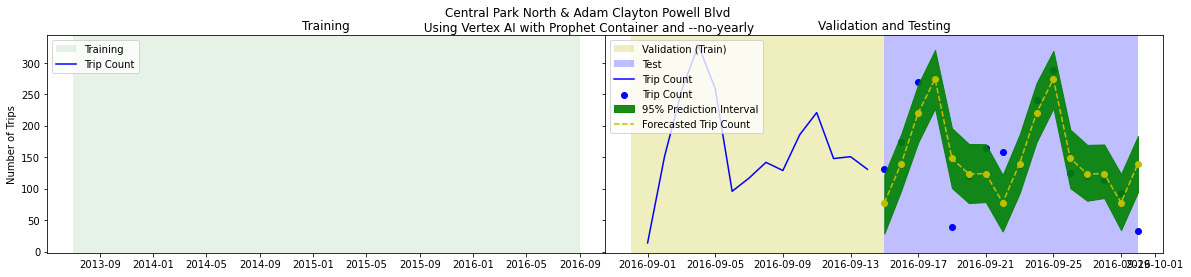

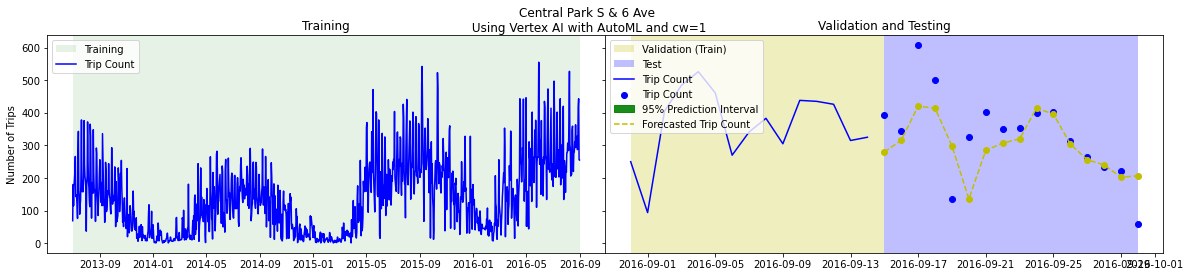

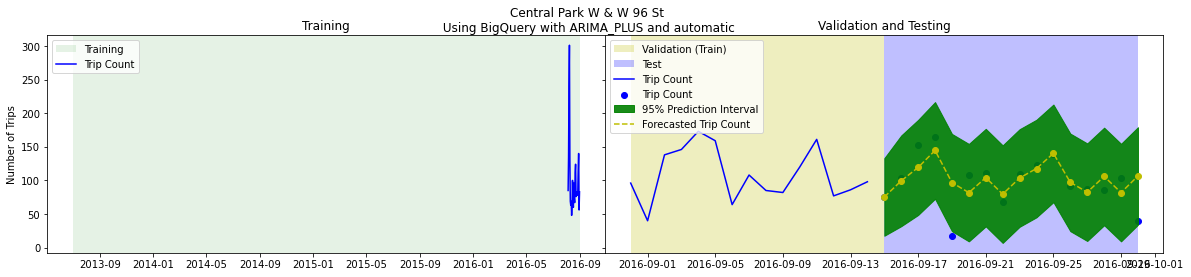

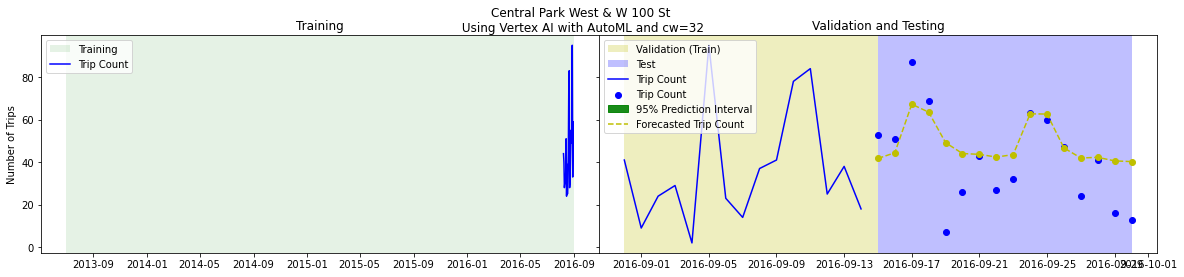

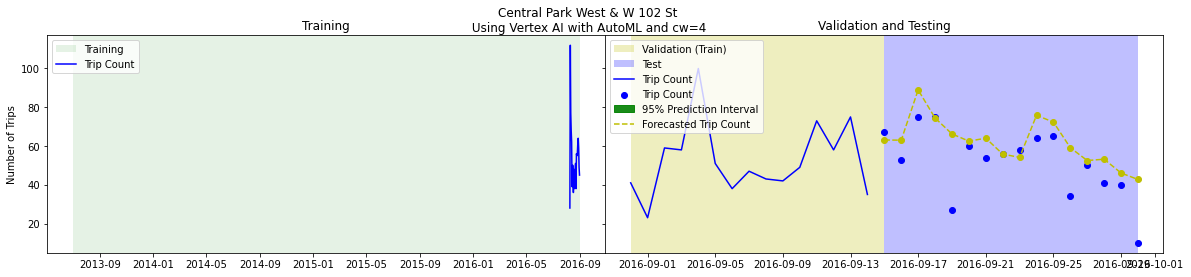

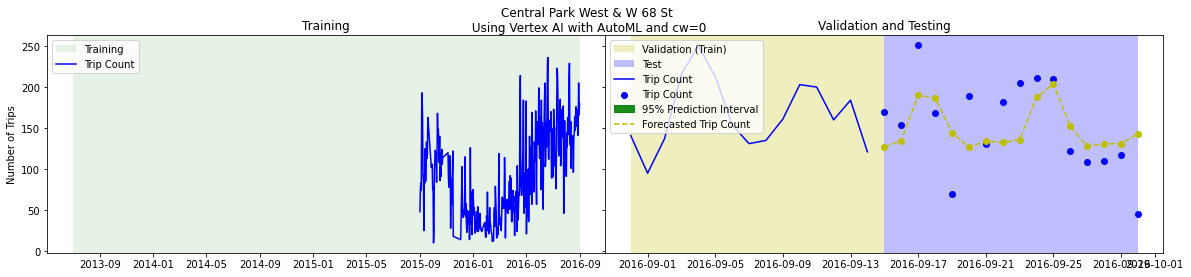

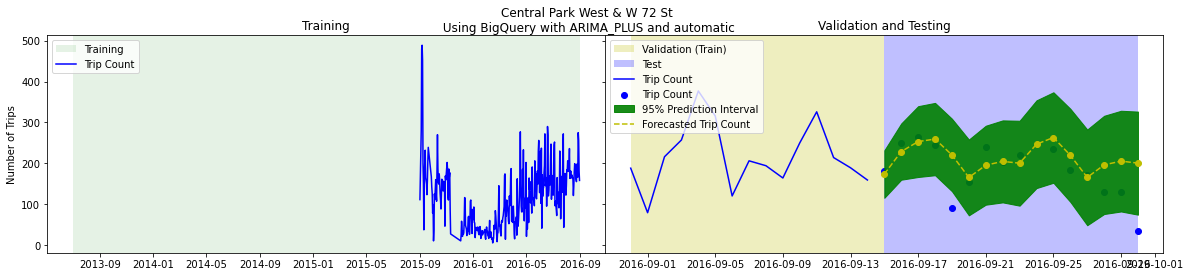

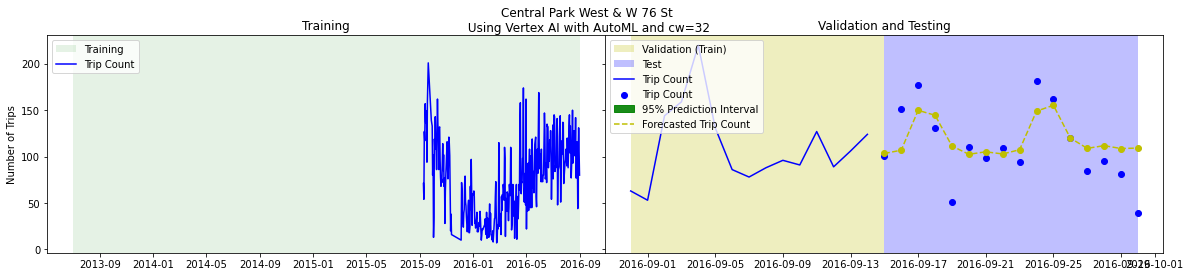

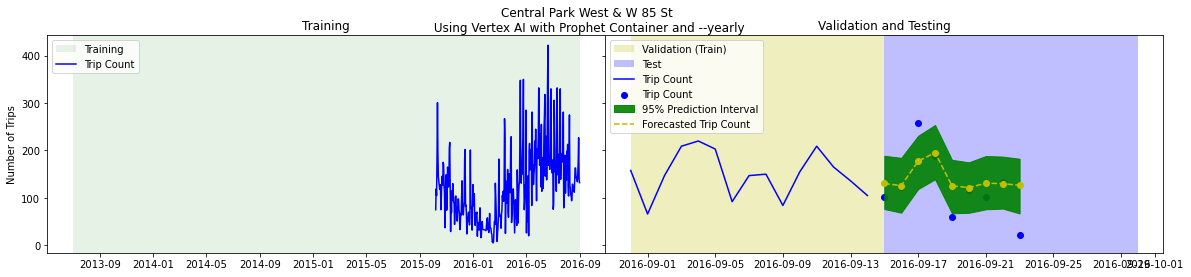

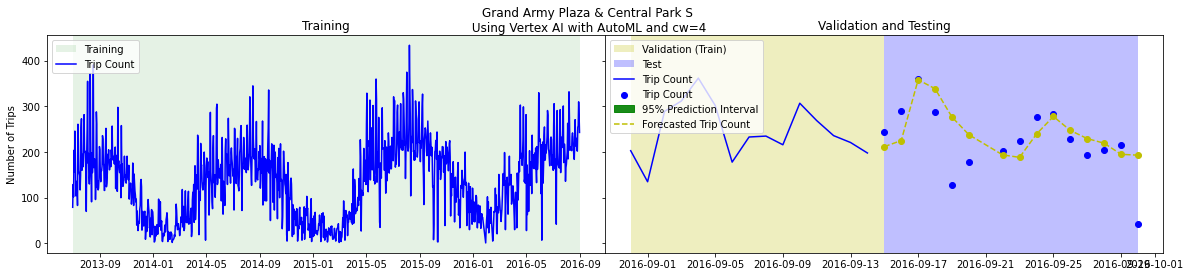

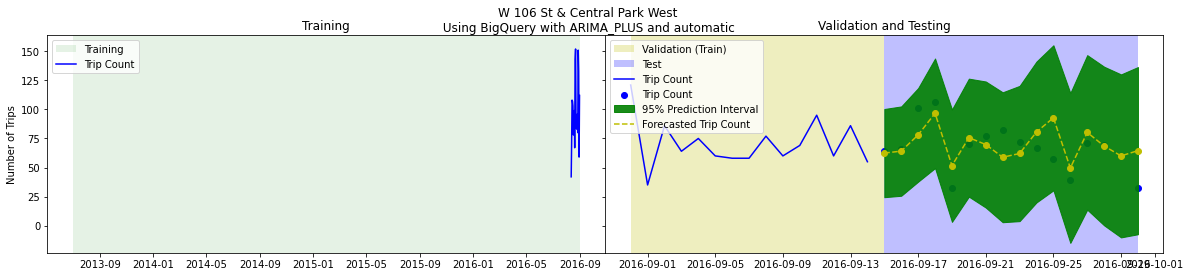

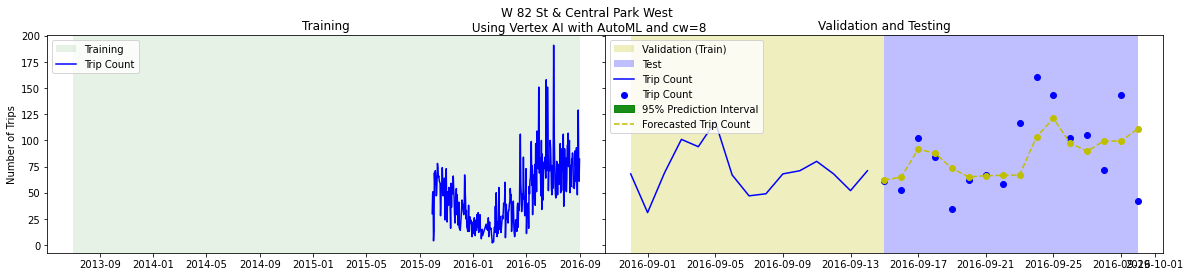

In [260]:
stations = rawSeries['start_station_name'].unique().tolist()
for s, st in enumerate(stations):
    # setup plot area
    fig, axes = plt.subplots(1, 2, figsize=(20, 4), sharex=False, sharey=True)
    fig.subplots_adjust(wspace=0)
    
    # data
    traindf = rawSeries[(rawSeries['start_station_name'] == st) & (rawSeries['splits'] == 'TRAIN')]
    valdf = rawSeries[(rawSeries['start_station_name'] == st) & (rawSeries['splits'] == 'VALIDATE')]
    testdf = rawSeries[(rawSeries['start_station_name'] == st) & (rawSeries['splits'] == 'TEST')]
    fit_testdf = fitSeries[(fitSeries['start_station_name'] == st)]
    
    # regions
    axes[0].axvspan(keyDates['start_date'][0], keyDates['val_start'][0], facecolor='g', alpha = 0.1, label = 'Training')
    axes[1].axvspan(keyDates['val_start'][0], keyDates['test_start'][0], facecolor='y', alpha = 0.25, label = 'Validation (Train)')
    axes[1].axvspan(keyDates['test_start'][0], keyDates['end_date'][0], facecolor='b', alpha = 0.25, label = 'Test')
    
    # plot raw time series
    axes[0].plot(traindf['date'], traindf['num_trips'], color = 'b', label = 'Trip Count')
    axes[1].plot(valdf['date'], valdf['num_trips'], color = 'b', label = 'Trip Count')
    axes[1].scatter(testdf['date'], testdf['num_trips'], color = 'b', label = 'Trip Count')
    
    # plot fitted test data
    axes[1].fill_between(fit_testdf['date'], fit_testdf['yhat_lower'], fit_testdf['yhat_upper'], color = 'g', alpha = 0.9, label = '95% Prediction Interval')
    axes[1].plot(fit_testdf['date'], fit_testdf['yhat'], color = 'y', label = 'Forecasted Trip Count', linestyle='dashed')
    axes[1].scatter(fit_testdf['date'], fit_testdf['yhat'], color = 'y')
    
    # labels
    axes[0].set_ylabel('Number of Trips')
    axes[0].set_title('Training')
    axes[1].set_title('Validation and Testing')
    axes[1].legend(loc = 'upper left')
    axes[0].legend(loc = 'upper left')
    
    # title
    platform, method, scenario = fitSeries[fitSeries['start_station_name'] == st][['platform','method','scenario']].iloc[0]
    plt.suptitle(st + f"\n Using {platform} with {method} and {scenario}")

    # display result
    plt.show()